<a href="https://colab.research.google.com/github/NikNord174/portfolio_optimization/blob/main/Return_Volatility_Sharpe%20Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install fix_yahoo_finance

In [ ]:
!pip install pandas_datareader --upgrade

In [265]:
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [266]:
tickers = ['AAPL', 'MSFT', 'TWTR', 'IBM']
start = dt.datetime(2020, 1, 1)
data = pdr.get_data_yahoo(tickers, start)
data = data['Adj Close']
data

Symbols,AAPL,MSFT,TWTR,IBM
Date,,,,
2020-01-02,73.894341,157.289871,32.299999,115.261650
2020-01-03,73.175926,155.331360,31.520000,114.342422
2020-01-06,73.759010,155.732849,31.639999,114.138145
2020-01-07,73.412117,154.312927,32.540001,114.214745
2020-01-08,74.593040,156.770889,33.049999,115.168022
...,...,...,...,...
2022-03-22,168.820007,304.059998,38.430000,129.059998
2022-03-23,170.210007,299.489990,38.000000,128.300003
2022-03-24,174.070007,304.100006,38.820000,129.250000


In [366]:
class Portfolio_Effectiveness():

  """
  -------------
  The class is for calculation of effective portfolio based on data about n assets
  -------------
  number_of_cycles - parameter of Monte-Carlo algorithm, the amount of points in experiment results
  data_for_assets  - data about choosen assets, obtained for a certain amount of time
  (imported data must include adjusted close price only)
  -------------
  Risk-free assets return is taken as 0
  -------------
  List of calling functions:
 • Minimum volatility:       Portfolio_Effectiveness().min_volatility()
 • Maximum Sharpe Ratio:     Portfolio_Effectiveness().max_sharpe_index() 
 • Efficient risk:           Portfolio_Effectiveness().efficient_risk(target_return)
 • Efficient return:         Portfolio_Effectiveness().efficient_return(target_risk)
 • Maximum Diversification:  Portfolio_Effectiveness().maximum_diversification()
  """

  def __init__(self, data_for_assets):
    self.predata=pd.DataFrame(data_for_assets)
    self.data=(self.predata/self.predata.shift()-1).dropna() #convert data to DataFrame in case it is not
    self.n_assets=self.data.shape[1]                         #number of assets

  #forming portfolio with random weights
  def get_portfolio(self,weights): 
    values=(self.data*weights).sum(axis=1)
    portfolio=pd.DataFrame(data={'portfolio':values},index=self.data.index)
    portfolio=(portfolio/portfolio.shift()-1).dropna()
    return portfolio

  #daily average return for every asset
  def get_return(self, data):
    return data.mean().values

  #daily average return for a portfolio
  def get_portfolio_return(self,weights): 
    values=(self.data*weights).sum(axis=1)
    return values.mean()

  #std for every asset return
  def get_std(self, data): 
    return data.std().values

  #std fordaily return of portfolio
  def get_portfolio_std(self,weights):
    values=(self.data*weights).sum(axis=1)
    return values.std()

  #get weights for minimal risk at certain a target return
  def efficient_risk(self, target_return): 
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)},
                 {'type':'eq', 'args':(data,), 'fun':lambda inputs,data:
                  target_return - self.get_portfolio_return(weights=inputs)})
    
    weights = scipy.optimize.minimize(self.get_portfolio_std,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

  def get_neg_portfolio_return(self,weights): 
    values=(self.data*weights).sum(axis=1)
    return -values.mean()

  #get weights for maximal return at certain a target risk
  def efficient_return(self, target_risk): 
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)},
                 {'type':'eq', 'args':(data,), 'fun':lambda inputs,data:
                  target_risk - self.get_portfolio_std(weights=inputs)})
    
    weights = scipy.optimize.minimize(self.get_neg_portfolio_return,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

  def volatility(self,weights):
    ret_cov=(self.data*weights).cov()
    return np.sqrt(np.dot(weights.T, np.dot(ret_cov, weights)))

  #get weights for portfolio with minimal volatility
  def min_volatility(self): 
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)})
    
    weights = scipy.optimize.minimize(self.volatility,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

  def min_volatility_with_return(self,target_return): #get weights for portfolio with minimal volatility
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)},
                 {'type':'eq', 'args':(data,), 'fun':lambda inputs,data:
                  target_return - self.get_portfolio_return(weights=inputs)})
    
    weights = scipy.optimize.minimize(self.volatility,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

  def neg_sharpe_ratio(self, weights):
    return -self.get_portfolio_return(weights)/self.get_portfolio_std(weights)

  #get weights for portfolio with max Sharpe Index
  def max_sharpe_ratio(self): 
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)})
    
    weights = scipy.optimize.minimize(self.neg_sharpe_ratio,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

  def neg_diversification(self,weights):
    num=np.dot(weights.T,self.get_std(self.data))
    ret_cov=(self.data*weights).cov()
    den=np.sqrt(np.dot(weights.T,np.dot(ret_cov,weights)))
    return -num/den

  #get weights for portfolio with max diversification ratio (according to Choueifaty, Yves, and Yves Coignard. 2008. “Toward Maximum Diversification.”)
  def max_diversification(self): 
    data=self.predata
    bounds = ((0.0, 1.0),)*self.n_assets
    init_weights=np.ones(self.n_assets)*(1/self.n_assets)
    cons=({'type':'eq', 'fun':lambda inputs: 1.0 - np.sum(inputs)})
    
    weights = scipy.optimize.minimize(self.neg_diversification,
                                      init_weights,
                                      method='SLSQP',
                                      options={'disp':False},
                                      constraints=cons,
                                      bounds=bounds)
    return weights.x

In [363]:
print(tickers)
PE=Portfolio_Effectiveness(data)
#print(PE.get_return(data))
#print(PE.get_std(data))
#print(PE.get_portfolio_return([0.25,0.25,0.25,0.25]))
#print(PE.get_portfolio_std(PE.max_sharpe_ratio()))
#print(PE.volatility(PE.max_sharpe_ratio()))
#print(PE.efficient_return(0.019))
#print(PE.max_sharpe_ratio())
#print(PE.min_volatility_with_return(0.0001))
print(PE.max_diversification())

['AAPL', 'MSFT', 'TWTR', 'IBM']
[0.23869249 0.24240862 0.22477198 0.29412691]


In [364]:
ret=np.arange(0.0003,0.002,0.00005)
vol=[]
for i in ret:
  a=PE.volatility(PE.min_volatility_with_return(i))
  vol.append(a)

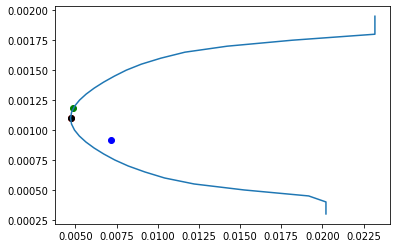

In [365]:
plt.plot(vol,ret)
plt.scatter(min(vol),ret[np.argmin(vol)],c='red')
plt.scatter(PE.volatility(PE.max_sharpe_ratio()),
            PE.get_portfolio_return(PE.max_sharpe_ratio()),c='green')
plt.scatter(PE.volatility(PE.efficient_return(0.0015)),
            PE.get_portfolio_return(PE.efficient_return(0.0015)),c='blue')
plt.scatter(PE.volatility(PE.max_diversification()),
            PE.get_portfolio_return(PE.max_diversification()),c='black')
plt.show()

In [334]:
ret=np.arange(0.0003,0.002,0.00005)
risk=[]
for i in ret:
  a=PE.get_portfolio_std(PE.optimize(i))
  risk.append(a)

plt.plot(risk,ret)
plt.scatter(min(risk),ret[np.argmin(risk)],c='red')
plt.show()

AttributeError: ignored

In [329]:
PE.max_sharpe_ratio()
PE.efficient_return(0.019)

array([0.25074448, 0.25694697, 0.20081832, 0.29149023])

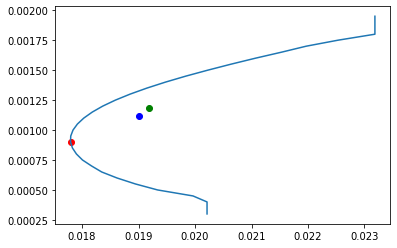

In [328]:
plt.plot(risk,ret)
plt.scatter(min(risk),ret[np.argmin(risk)],c='red')
plt.scatter(PE.get_portfolio_std(PE.max_sharpe_ratio()),
            PE.get_portfolio_return(PE.max_sharpe_ratio()),c='green')
plt.scatter(PE.get_portfolio_std(PE.efficient_return(0.019)),
            PE.get_portfolio_return(PE.efficient_return(0.019)),c='blue')
plt.show()

In [331]:
!pip install pypfopt

ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt


In [330]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

#mu = mean_historical_return(df)
#S = CovarianceShrinkage(df).ledoit_wolf()

ModuleNotFoundError: ignored